SRGAN Training with Custom Perceptual Loss

In this notebook, we train a Super-Resolution Generative Adversarial Network (SRGAN) to upscale images from 32x32 to 128x128. We incorporate a pre-trained classifier (model A) into the SRGAN's perceptual loss function to improve the quality of generated images. After training, we generate new high-resolution images using the trained SRGAN.

In [1]:
# Import Modules/Libraries
import math
import os
from os.path import join
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import save_image
from PIL import Image
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from math import log10
import pytorch_ssim

In [2]:
# Set Random Seed and Device Configuration
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Prepare the Dataset

def is_image_file(filename):
    """Check if a file is an image."""
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

class TrainDatasetFromFolder(Dataset):
    """Custom Dataset for training."""
    def __init__(self, image_filenames, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = image_filenames
        self.lr_transform = transforms.Compose([
            transforms.Resize((32, 32), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((128, 128), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        # Load image
        image_filename = self.image_filenames[index]
        image = Image.open(image_filename).convert('RGB')
        # Apply transforms
        lr_image = self.lr_transform(image)
        hr_image = self.hr_transform(image)
        # Extract label from filename
        label = os.path.basename(image_filename).split('.')[0]  # 'cat' or 'dog'
        return lr_image, hr_image, label

    def __len__(self):
        return len(self.image_filenames)

class ValDatasetFromFolder(Dataset):
    """Custom Dataset for validation/testing."""
    def __init__(self, image_filenames, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.image_filenames = image_filenames
        self.lr_transform = transforms.Compose([
            transforms.Resize((32, 32), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((128, 128), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        # Load image
        image_filename = self.image_filenames[index]
        image = Image.open(image_filename).convert('RGB')
        # Apply transforms
        lr_image = self.lr_transform(image)
        hr_image = self.hr_transform(image)
        # Extract label from filename
        label = os.path.basename(image_filename).split('.')[0]  # 'cat' or 'dog'
        return lr_image, hr_image, label

    def __len__(self):
        return len(self.image_filenames)

In [4]:
# Parameters
upscale_factor = 4  # Since LR is 32x32 and HR is 128x128, 128 / 32 = 4

# Get all image paths
image_paths = [join('dataset/train', x) for x in os.listdir('dataset/train') if is_image_file(x)]
random.shuffle(image_paths)
train_size = int(0.7 * len(image_paths))  # 70% for training
train_image_paths = image_paths[:train_size]
test_image_paths = image_paths[train_size:]  # 30% for testing

# Create datasets
train_set = TrainDatasetFromFolder(train_image_paths, upscale_factor)
test_set = ValDatasetFromFolder(test_image_paths, upscale_factor)

# Create DataLoaders
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, num_workers=0, batch_size=1, shuffle=False)

Processing images: 100%|██████████| 5/5 [00:00<00:00, 161.45it/s]


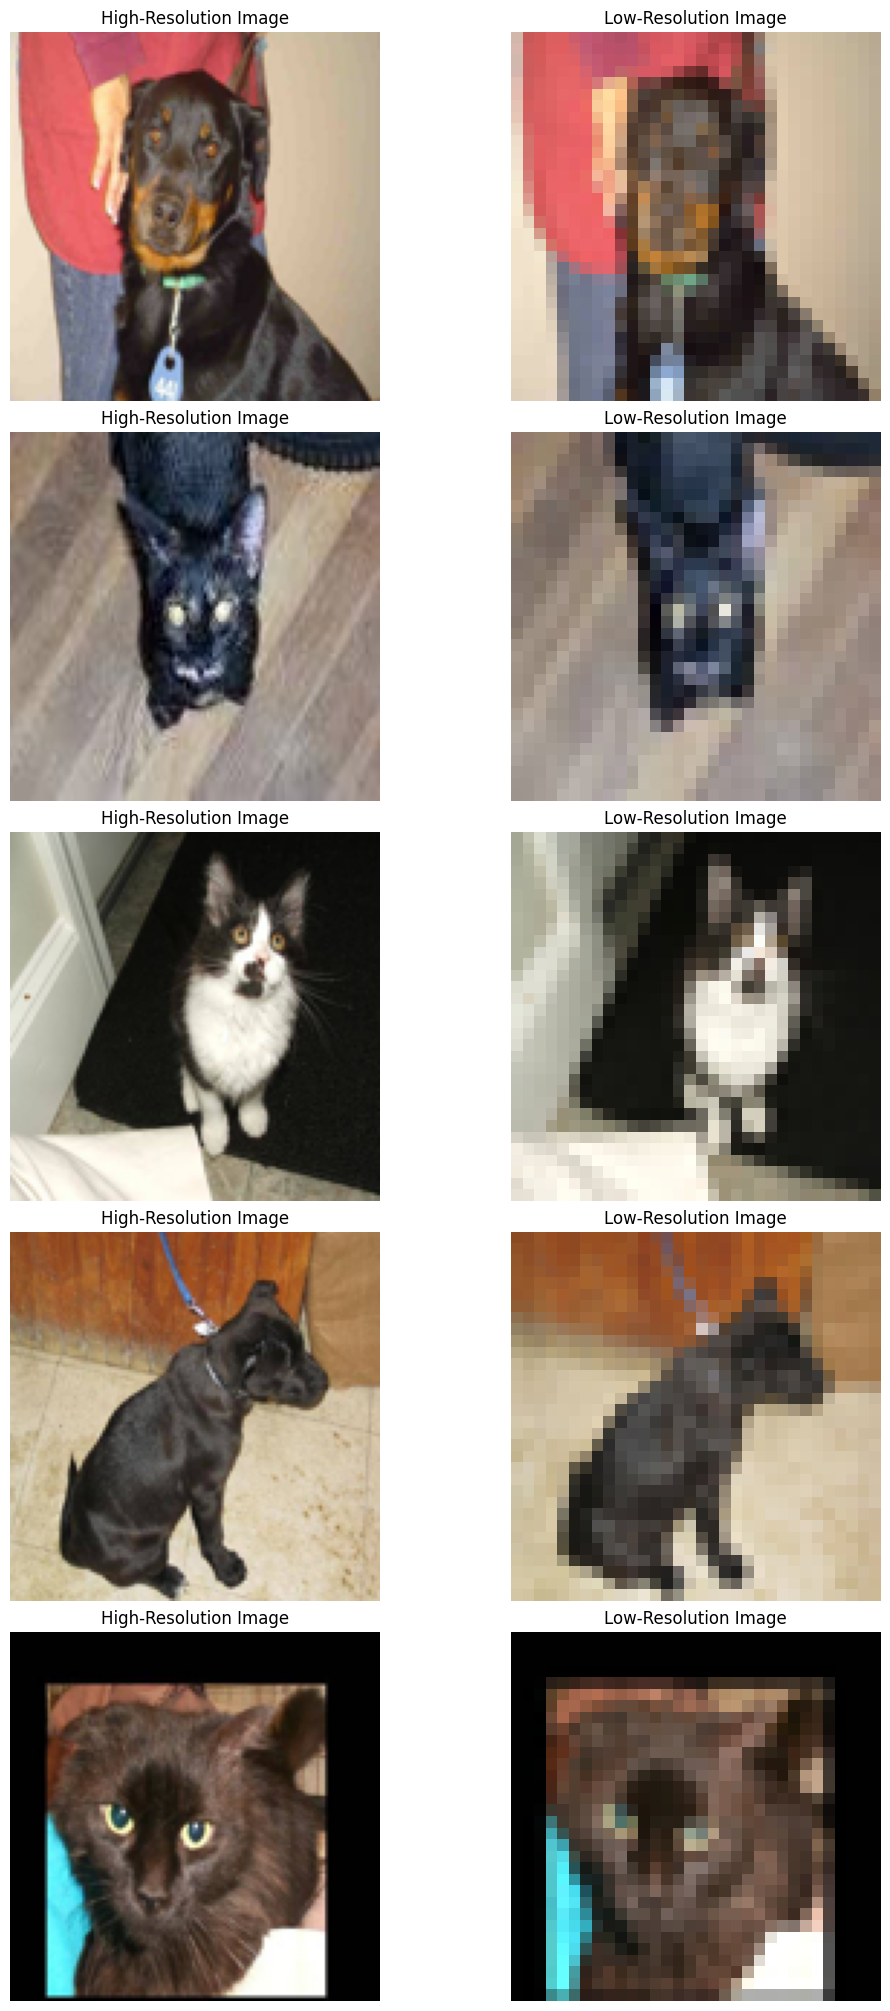

In [5]:
# Show Examples of Original and Downscaled Images

# Number of examples to display
num_examples = 5
fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 4), constrained_layout=True)

for idx in tqdm(range(num_examples), desc="Processing images"):
    img_path = train_set.image_filenames[idx]
    # Load the original image
    original_image = Image.open(img_path).convert('RGB')
    # Apply the LR and HR transforms
    lr_image = train_set.lr_transform(original_image)
    hr_image = train_set.hr_transform(original_image)
    # Convert tensors to images
    hr_image_np = hr_image.permute(1, 2, 0).numpy()
    lr_image_np = lr_image.permute(1, 2, 0).numpy()
    hr_image_np = np.clip(hr_image_np, 0, 1)
    lr_image_np = np.clip(lr_image_np, 0, 1)
    # Display images
    axes[idx, 0].imshow(hr_image_np)
    axes[idx, 0].set_title('High-Resolution Image')
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(lr_image_np)
    axes[idx, 1].set_title('Low-Resolution Image')
    axes[idx, 1].axis('off')

# plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/srgan_train_data_original_and_downscaled_images.png')

plt.show()
plt.close()  # Close the figure to free up memory

In [6]:
# Load Pre-trained Classifier (Model A) for Perceptual Loss

# Load your pre-trained classifier (model A)
classifier = models.vgg16()
classifier.classifier[6] = nn.Linear(4096, 2)  # Assuming binary classification (cats and dogs)
classifier.load_state_dict(torch.load('models/classifier_model_A.pth', weights_only=True))
classifier.eval()
classifier.to(device)

# Freeze the classifier parameters
for param in classifier.parameters():
    param.requires_grad = False

class FeatureExtractor(nn.Module):
    """Extract features from your classifier for perceptual loss."""
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Use features up to a specific layer (e.g., 'conv4_3')
        self.features = nn.Sequential(*list(model.features.children())[:23])  # Adjust the layer as needed

    def forward(self, x):
        return self.features(x)

# Initialize Feature Extractor
feature_extractor = FeatureExtractor(classifier).to(device)
feature_extractor.eval()

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [7]:
# Load Pre-trained VGG16 for Perceptual Loss

# class FeatureExtractor(nn.Module):
#     """Extract features from VGG16 for perceptual loss."""
# 
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         vgg16 = models.vgg16(pretrained=True)
#         # Use layers up to layer 31 (up to 'conv4_3' in VGG16)
#         self.features = nn.Sequential(*list(vgg16.features)[:31])
#         for param in self.features.parameters():
#             param.requires_grad = False  # Freeze VGG16 parameters
# 
#     def forward(self, x):
#         return self.features(x)
# 
# 
# # Initialize Feature Extractor
# feature_extractor = FeatureExtractor().to(device)
# feature_extractor.eval()

In [8]:
# Define SRGAN Models (Generator and Discriminator)
class ResidualBlock(nn.Module):
    """Residual Block with two convolutional layers."""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class UpsampleBLock(nn.Module):
    """Upsample Block using PixelShuffle."""
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class Generator(nn.Module):
    """Generator network for SRGAN."""
    def __init__(self, scale_factor):
        super(Generator, self).__init__()
        upsample_block_num = int(math.log(scale_factor, 2))
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)]  # Increased number of residual blocks
        )
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        upsample_blocks = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        upsample_blocks.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*upsample_blocks)

    def forward(self, x):
        block1 = self.block1(x)
        residual = self.residual_blocks(block1)
        block7 = self.block7(residual)
        block8 = self.block8(block1 + block7)
        return (torch.tanh(block8) + 1) / 2

class Discriminator(nn.Module):
    """Discriminator network for SRGAN."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [9]:
# Define Custom Loss Functions

# GeneratorLoss for Pre-trained VGG16
# class GeneratorLoss(nn.Module):
#     def __init__(self):
#         super(GeneratorLoss, self).__init__()
#         self.mse_loss = nn.MSELoss()
#         self.tv_loss = TVLoss()
#         self.loss_network = feature_extractor
# 
#     def forward(self, fake_outputs, fake_images, real_images):
#         # Adversarial Loss: mean(1 - D(G(z)))
#         adversarial_loss = torch.mean(1 - fake_outputs)
#         # Content Loss: MSE between fake and real images
#         content_loss = self.mse_loss(fake_images, real_images)
#         # Perceptual Loss: MSE between features of fake and real images
#         perception_loss = self.mse_loss(self.loss_network(fake_images), self.loss_network(real_images))
#         # Total Variation Loss
#         tv_loss = self.tv_loss(fake_images)
#         # Total Generator Loss
#         total_loss = content_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss
#         return total_loss, content_loss, adversarial_loss, perception_loss, tv_loss
    
# GeneratorLoss for pre-trained classifier (model A)
class GeneratorLoss(nn.Module):
    def __init__(self, feature_extractor):
        super(GeneratorLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
        self.loss_network = feature_extractor

    def forward(self, fake_outputs, fake_images, real_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - fake_outputs)
        # Content Loss
        content_loss = self.mse_loss(fake_images, real_images)
        # Perceptual Loss
        perception_loss = self.mse_loss(self.loss_network(fake_images), self.loss_network(real_images))
        # TV Loss
        tv_loss = self.tv_loss(fake_images)
        # Total Generator Loss
        total_loss = content_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss
        return total_loss, content_loss, adversarial_loss, perception_loss, tv_loss

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size(0)
        h_x = x.size(2)
        w_x = x.size(3)
        count_h = self._tensor_size(x[:, :, 1:, :])
        count_w = self._tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def _tensor_size(t):
        return t.size(1) * t.size(2) * t.size(3)

# Instantiate the loss functions
generator_criterion = GeneratorLoss(feature_extractor).to(device)
criterion_d = nn.BCELoss().to(device)

In [10]:
# Initialize Models and Optimizers

# Initialize models
netG = Generator(upscale_factor).to(device)
netD = Discriminator().to(device)

# Optimizers
# optimizerG = optim.Adam(netG.parameters(), lr=1e-4)
optimizerG = optim.Adam(netG.parameters(), lr=1e-4)
# optimizerG = optim.Adam(netG.parameters())
# optimizerG = optim.Adam(netG.parameters(), lr=1e-5)
# optimizerD = optim.Adam(netD.parameters(), lr=1e-4)
optimizerD = optim.Adam(netD.parameters(), lr=1e-5)
# optimizerD = optim.Adam(netD.parameters(), lr=1e-6)
# optimizerD = optim.Adam(netD.parameters())

# Print the number of parameters (optional)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 1549462
# discriminator parameters: 5215425


In [11]:
# num_epochs = 1 # test
# num_epochs = 2 # test
# num_epochs = 5 # test
# num_epochs = 10 # test
num_epochs = 150

# Define the checkpoint path and starting epoch
checkpoint_path = 'models/srgan_checkpoint.pth'
start_epoch = 1  # Default starting epoch

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}

# Attempt to load checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    netG.load_state_dict(checkpoint['generator_state_dict'])
    netD.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizer_g_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizer_d_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from the next epoch
    results['g_loss'] = checkpoint.get('g_losses', [])
    results['d_loss'] = checkpoint.get('d_losses', [])
    if start_epoch >= num_epochs:
        print(f"Training already completed. The model has been trained for {start_epoch} epochs.")
    else:
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Starting training from scratch.")

# Training Loop
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}

for epoch in range(start_epoch, num_epochs + 1):
    train_bar = tqdm(train_loader)
    running_results = {
        'batch_sizes': 0,
        'd_loss': 0.0,
        'g_loss': 0.0,
        'd_score': 0.0,
        'g_score': 0.0,
        'content_loss': 0.0,
        'adversarial_loss': 0.0,
        'perception_loss': 0.0,
        'tv_loss': 0.0,
    }

    netG.train()
    netD.train()

    for data, target, _ in train_bar:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        # Prepare data
        real_img = target.to(device)  # High-resolution images
        z = data.to(device)           # Low-resolution images

        # Generate fake images
        fake_img = netG(z)

        # Update D network
        netD.zero_grad()
        real_out = netD(real_img)
        fake_out = netD(fake_img.detach())
        # real_labels = torch.ones_like(real_out, device=device)
        real_labels = torch.full_like(real_out, 0.8, device=device)
        fake_labels = torch.zeros_like(fake_out, device=device)

        d_loss_real = criterion_d(real_out, real_labels)
        d_loss_fake = criterion_d(fake_out, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Update G network
        netG.zero_grad()
        fake_out_for_g = netD(fake_img)
        g_loss, content_loss, adversarial_loss, perception_loss, tv_loss = generator_criterion(fake_out_for_g, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        # Record the losses and scores
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.mean().item() * batch_size
        running_results['g_score'] += fake_out.mean().item() * batch_size
        
        running_results['content_loss'] += content_loss.item() * batch_size
        running_results['adversarial_loss'] += adversarial_loss.item() * batch_size
        running_results['perception_loss'] += perception_loss.item() * batch_size
        running_results['tv_loss'] += tv_loss.item() * batch_size
        
        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f Content: %.4f Adv: %.4f Perc: %.4f TV: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, num_epochs,
            running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['content_loss'] / running_results['batch_sizes'],
            running_results['adversarial_loss'] / running_results['batch_sizes'],
            running_results['perception_loss'] / running_results['batch_sizes'],
            running_results['tv_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))


    # Record the results
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])

    # Save model checkpoint after each epoch
    checkpoint = {
        'generator_state_dict': netG.state_dict(),
        'discriminator_state_dict': netD.state_dict(),
        'optimizer_g_state_dict': optimizerG.state_dict(),
        'optimizer_d_state_dict': optimizerD.state_dict(),
        'epoch': epoch,
        'g_losses': results['g_loss'],
        'd_losses': results['d_loss']
    }
    os.makedirs('models', exist_ok=True)
    torch.save(checkpoint, 'models/srgan_checkpoint.pth')
    
# Save the final generator and discriminator models
torch.save(netG.state_dict(), 'models/srgan_generator_final.pth')
torch.save(netD.state_dict(), 'models/srgan_discriminator_final.pth')
print("Final models saved.")

No checkpoint found. Starting training from scratch.


[1/150] Loss_D: 1.1052 Loss_G: 0.0171 Content: 0.0088 Adv: 0.6846 Perc: 1.2639 TV: 0.0056 D(x): 0.4990 D(G(z)): 0.3208: 100%|██████████| 274/274 [02:06<00:00,  2.16it/s]
[2/150] Loss_D: 0.7565 Loss_G: 0.0111 Content: 0.0045 Adv: 0.8532 Perc: 0.9611 TV: 0.0063 D(x): 0.6538 D(G(z)): 0.1534: 100%|██████████| 274/274 [02:04<00:00,  2.21it/s]
[3/150] Loss_D: 0.5754 Loss_G: 0.0104 Content: 0.0041 Adv: 0.9450 Perc: 0.8924 TV: 0.0062 D(x): 0.7526 D(G(z)): 0.0553: 100%|██████████| 274/274 [02:04<00:00,  2.21it/s]
[4/150] Loss_D: 0.5380 Loss_G: 0.0100 Content: 0.0039 Adv: 0.9729 Perc: 0.8557 TV: 0.0062 D(x): 0.7777 D(G(z)): 0.0272: 100%|██████████| 274/274 [02:05<00:00,  2.18it/s]
[5/150] Loss_D: 0.5228 Loss_G: 0.0097 Content: 0.0038 Adv: 0.9846 Perc: 0.8281 TV: 0.0063 D(x): 0.7877 D(G(z)): 0.0155: 100%|██████████| 274/274 [02:06<00:00,  2.17it/s]
[6/150] Loss_D: 0.5148 Loss_G: 0.0095 Content: 0.0036 Adv: 0.9905 Perc: 0.8047 TV: 0.0064 D(x): 0.7923 D(G(z)): 0.0095: 100%|██████████| 274/274 [02:0

Final models saved.


In [12]:
# Validation Loop

# Use the test_loader for validation
netG.eval()
with torch.no_grad():
    val_bar = tqdm(test_loader)
    valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
    for val_lr, val_hr, _ in val_bar:
        batch_size = val_lr.size(0)
        valing_results['batch_sizes'] += batch_size
        lr = val_lr.to(device)
        hr = val_hr.to(device)
        sr = netG(lr)

        # Calculate MSE and SSIM
        batch_mse = ((sr - hr) ** 2).data.mean()
        valing_results['mse'] += batch_mse * batch_size
        batch_ssim = pytorch_ssim.ssim(sr, hr).item()
        valing_results['ssims'] += batch_ssim * batch_size

    # Calculate final metrics
    valing_results['psnr'] = 10 * log10(1 / (valing_results['mse'] / valing_results['batch_sizes']))
    valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']

    print('PSNR: %.4f dB SSIM: %.4f' % (valing_results['psnr'], valing_results['ssim']))

100%|██████████| 7500/7500 [01:36<00:00, 77.52it/s]

PSNR: 25.5679 dB SSIM: 0.7720


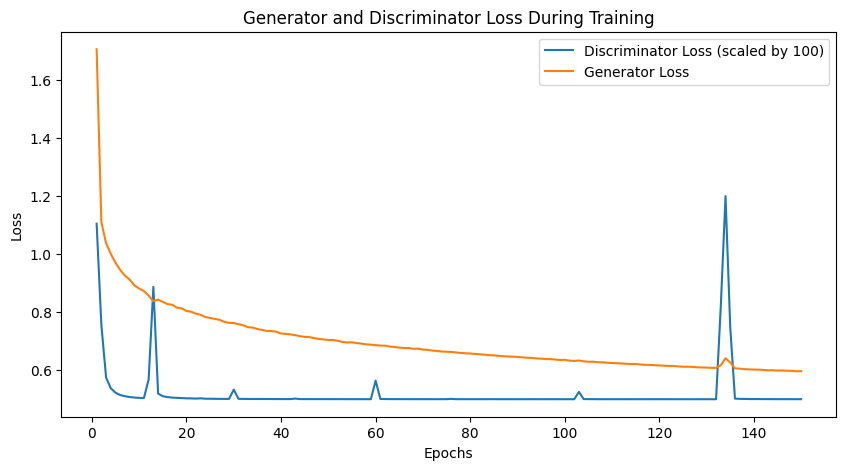

In [13]:
# Plot Training Losses

# Load the last checkpoint
last_epoch = num_epochs  # or the epoch you want to load
checkpoint_path = 'models/srgan_checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    g_losses = checkpoint.get('g_losses', [])
    d_losses = checkpoint.get('d_losses', [])

    if g_losses and d_losses:
        g_losses = [loss * 100 for loss in g_losses]
        plt.figure(figsize=(10, 5))
        epochs_range = range(1, last_epoch + 1)
        plt.plot(epochs_range, d_losses, label='Discriminator Loss (scaled by 100)')
        plt.plot(epochs_range, g_losses, label='Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Loss During Training')
        plt.legend()
        os.makedirs('figures', exist_ok=True)
        plt.savefig('figures/srgan_loss_plot.png')
        plt.show()
        plt.close()  # Close the figure to free up memory
    else:
        print("Loss data not found in the checkpoint.")
else:
    print("Checkpoint file not found.")

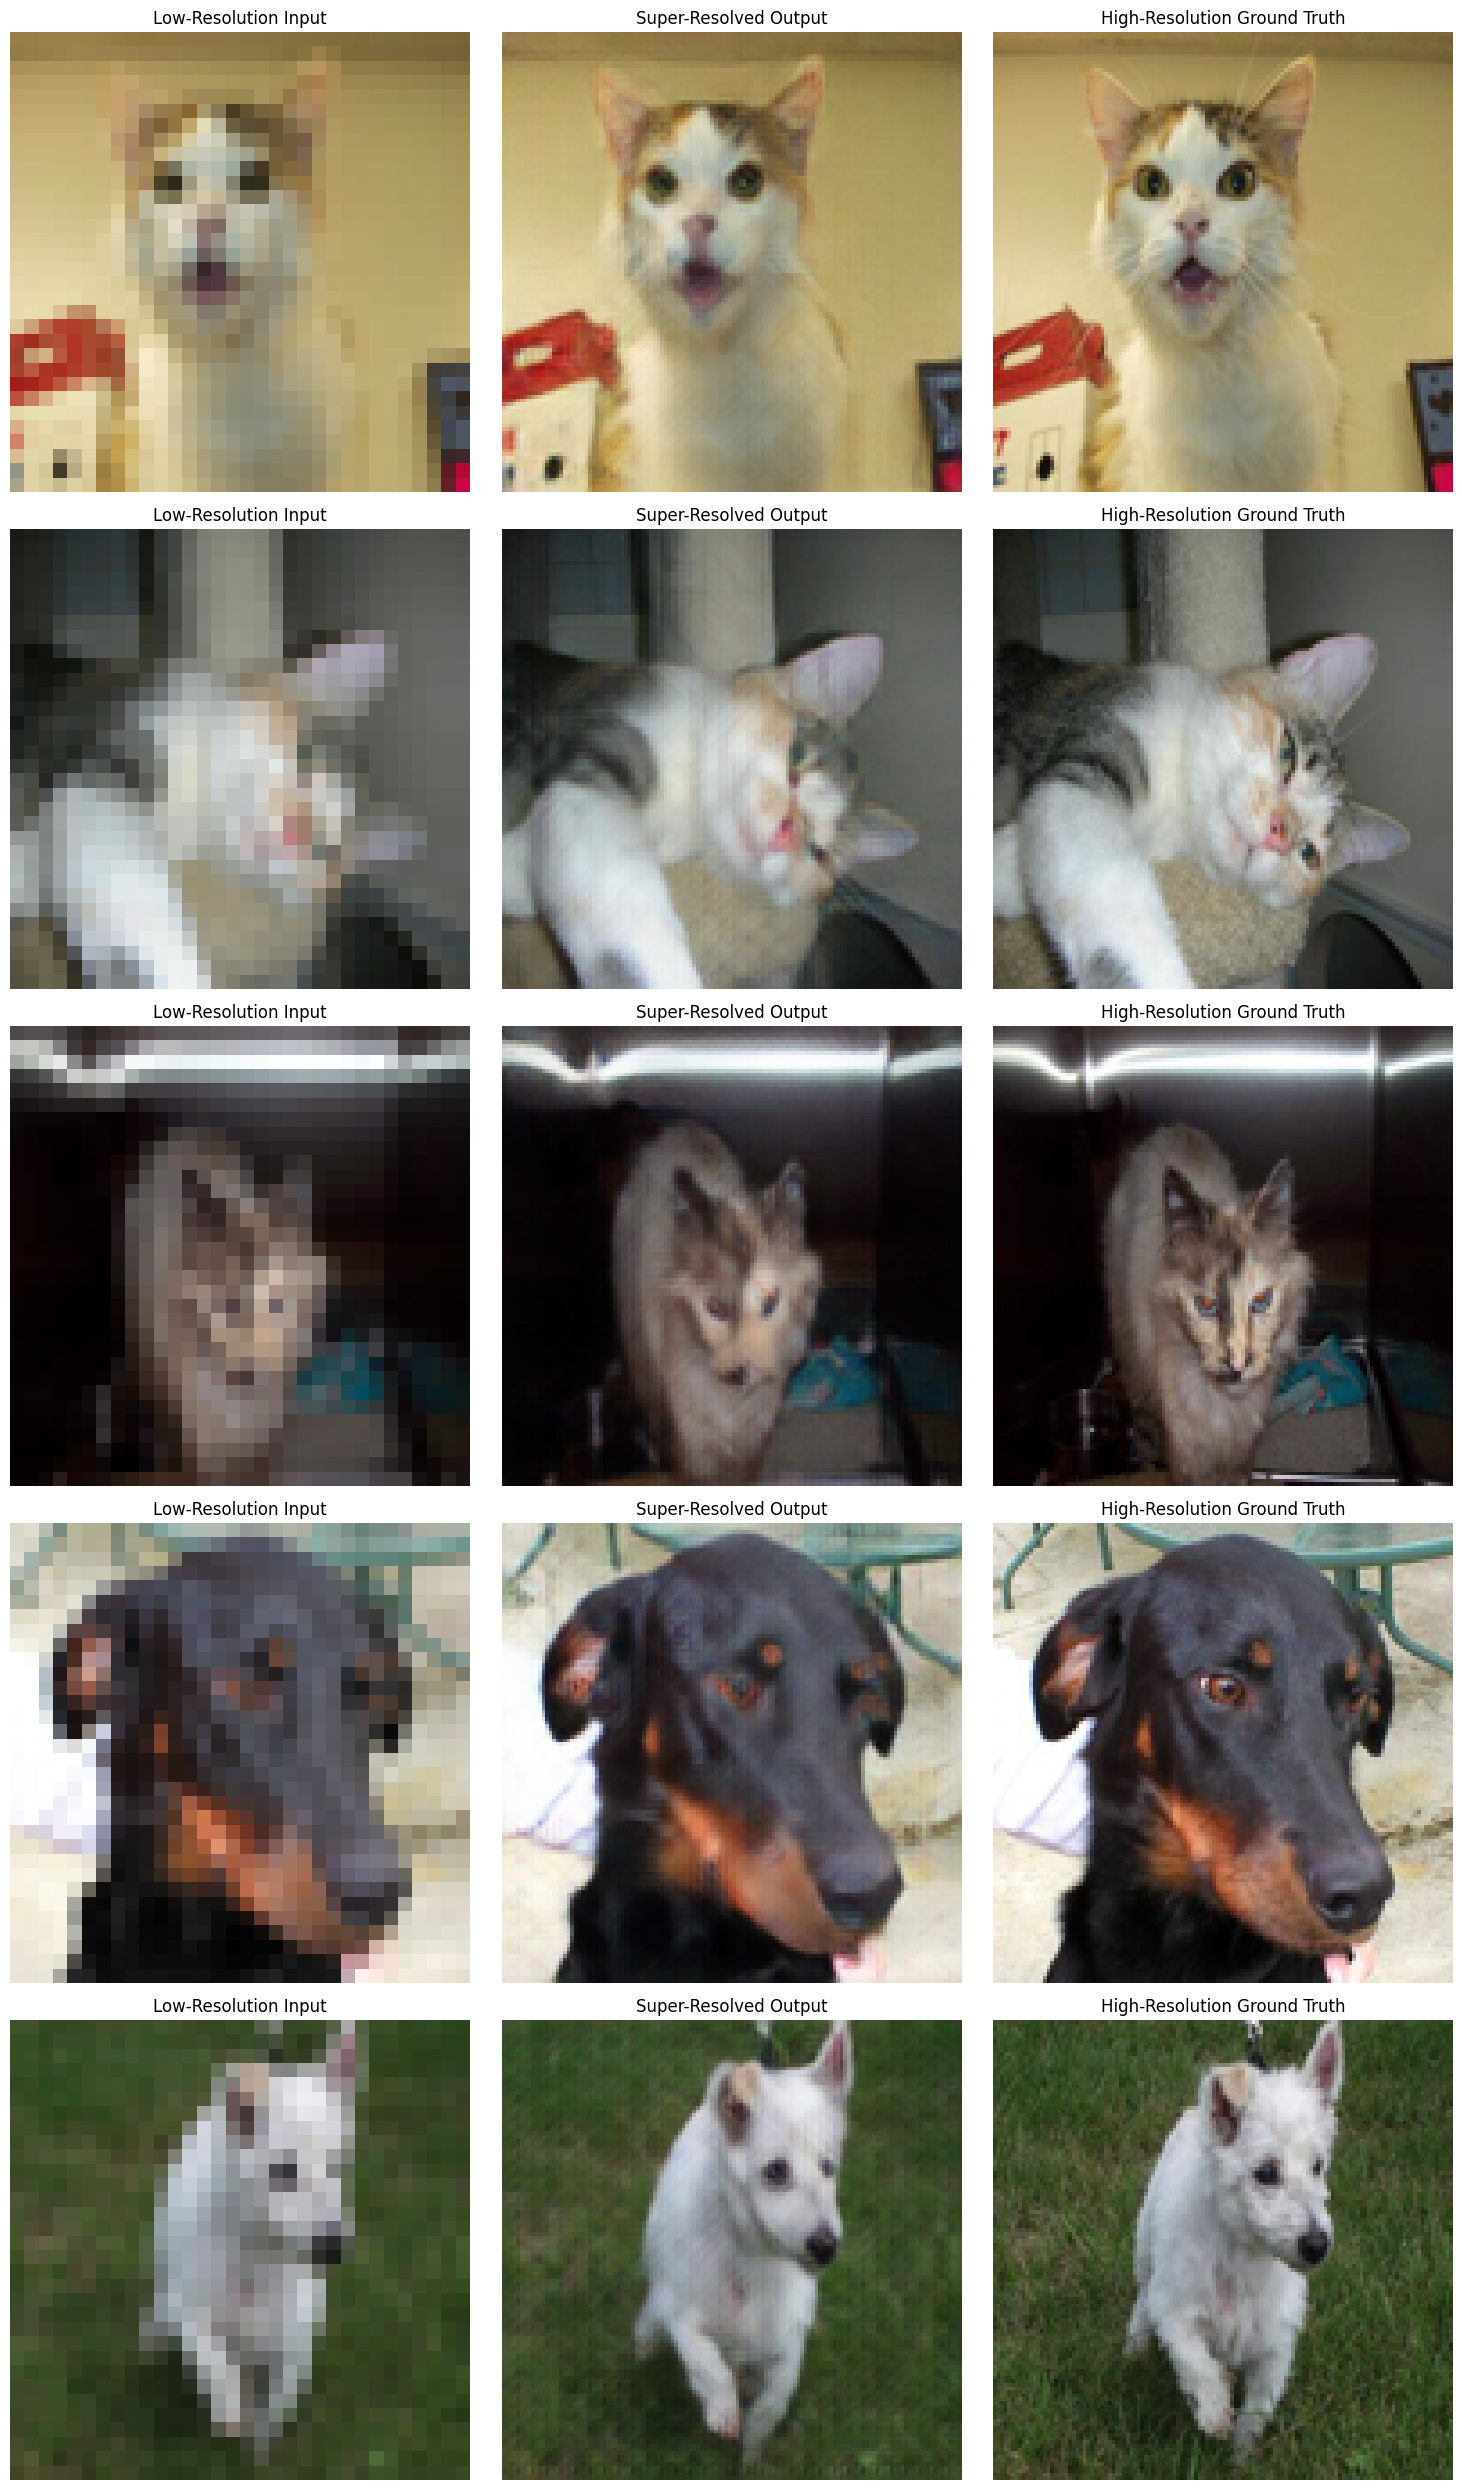

In [14]:
# Display Sample Images from Validation Set

# Number of examples to display
num_examples = 5
val_iter = iter(test_loader)
fig, axes = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))

for idx in range(num_examples):
    val_lr, val_hr, label = next(val_iter)
    val_lr = val_lr.to(device)
    val_hr = val_hr.to(device)
    with torch.no_grad():
        sr = netG(val_lr)
    # Convert tensors to images
    sr_image = sr.squeeze(0).cpu().permute(1, 2, 0).numpy()
    lr_image = val_lr.squeeze(0).cpu().permute(1, 2, 0).numpy()
    hr_image = val_hr.squeeze(0).cpu().permute(1, 2, 0).numpy()
    # Clip values to [0,1]
    sr_image = np.clip(sr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    hr_image = np.clip(hr_image, 0, 1)
    # Display images
    axes[idx, 0].imshow(lr_image)
    axes[idx, 0].set_title('Low-Resolution Input')
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(sr_image)
    axes[idx, 1].set_title('Super-Resolved Output')
    axes[idx, 1].axis('off')
    axes[idx, 2].imshow(hr_image)
    axes[idx, 2].set_title('High-Resolution Ground Truth')
    axes[idx, 2].axis('off')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/srgan_validation_sample_images.png')
plt.show()
plt.close()

In [15]:
# Generate High-Resolution Images Using Trained Generator

# Load trained generator model
generator = Generator(upscale_factor).to(device)
generator_path = 'models/srgan_checkpoint.pth'

if os.path.exists(generator_path):
    checkpoint = torch.load(generator_path, weights_only=True)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    print("Loaded generator model from '%s'" % generator_path)
else:
    raise FileNotFoundError("No trained generator model found. Please train the model before generating images.")

generator.eval()
output_dir = "dataset/gan_generate"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, (img_lr, img_hr, label) in enumerate(tqdm(test_loader, desc="Generating Images")):
        img_lr = img_lr.to(device)
        # Upscale images using the generator
        sr = generator(img_lr)
        # Save the generated image with label in filename
        save_path = os.path.join(output_dir, f"generated_{label[0]}_{i + 1}.jpg")
        save_image(sr.cpu(), save_path)
print("Generated high-resolution images.")

Loaded generator model from 'models/srgan_checkpoint.pth'


Generating Images: 100%|██████████| 7500/7500 [01:59<00:00, 62.87it/s]

Generated high-resolution images.
